In [177]:
# Install the required libraries
!pip install prophet
!pip install matplotlib

In [178]:
# Import the required libraries and dependencies
import pandas as pd
from prophet import Prophet
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator
%matplotlib inline

In [179]:
#Turned available csv sets (which were in Google sheets) to readable csv files
home_ownership_rate = pd.read_csv("Home Ownership Rate (Hamilton, OH) - Home Ownership Rate.csv")
us_census = pd.read_csv("US Census (Hamilton, OH) - Sheet1.csv")
home_value_forecast = pd.read_csv("Home Value Forecast - Sheet1.csv")
metro_sales_count = pd.read_csv("Metro Sales Count - Sheet1.csv")
new_construction_sales = pd.read_csv("New Construction Sales - Sheet1.csv")
zestimate = pd.read_csv("Zillow Housing Estimate Index - Sheet1.csv")

# How many people owns housing in Hamilton county
display(home_ownership_rate.head())

,DATE,HOWNRATEACS039061
0,1/1/2009,67.089647
1,1/1/2010,65.820411
2,1/1/2011,65.362558
3,1/1/2012,64.354125
4,1/1/2013,63.293043


In [180]:
# Shows the population for Hamilton county
us_census_transposed = us_census.set_index("Fact").transpose()

display(us_census_transposed) 

Fact,"Population estimates, July 1, 2023, (V2023)","Population Estimates, July 1, 2022, (V2022)","Population estimates base, April 1, 2020, (V2023)","Population estimates base, April 1, 2020, (V2022)","Population, percent change - April 1, 2020 (estimates base) to July 1, 2023, (V2023)","Population, percent change - April 1, 2020 (estimates base) to July 1, 2022, (V2022)","Population, Census, April 1, 2020","Population, Census, April 1, 2010","Persons under 5 years, percent","Persons under 18 years, percent",...,"Women-owned employer firms, Reference year 2017","Minority-owned employer firms, Reference year 2017","Nonminority-owned employer firms, Reference year 2017","Veteran-owned employer firms, Reference year 2017","Nonveteran-owned employer firms, Reference year 2017","Population per square mile, 2020","Population per square mile, 2010","Land area in square miles, 2020","Land area in square miles, 2010",FIPS Code
"Hamilton County, Ohio",NaN,"825,037",NaN,"830,625",NaN,-0.70%,"830,639","802,374",6.10%,22.60%,...,"2,735","1,150","11,949",846,"12,077","2,048.90","1,976.70",405.41,405.91,"""39061"""


In [181]:
#display(home_value_forecast) # A month-ahead, quarter-ahead and year-ahead forecast of the Zillow Home Value Index (ZHVI)
home_value_forecast_dropped = home_value_forecast.dropna()

display(home_value_forecast_dropped)

,RegionID,SizeRank,RegionName,RegionType,StateName,BaseDate,12/31/2023,2/29/2024,11/30/2024
1,394913,1,"New York, NY",msa,NY,11/30/2023,0.1,-0.5,-2.9
2,753899,2,"Los Angeles, CA",msa,CA,11/30/2023,0.3,-1.0,-2.2
3,394463,3,"Chicago, IL",msa,IL,11/30/2023,0.1,-0.3,-2.2
4,394514,4,"Dallas, TX",msa,TX,11/30/2023,-0.2,-0.8,-0.8
5,394692,5,"Houston, TX",msa,TX,11/30/2023,-0.3,-1.1,-2.0
...,...,...,...,...,...,...,...,...,...
890,753929,935,"Zapata, TX",msa,TX,11/30/2023,-1.6,-3.9,-9.5
891,394743,936,"Ketchikan, AK",msa,AK,11/30/2023,-0.5,-1.0,-3.8
892,753874,937,"Craig, CO",msa,CO,11/30/2023,0.0,-0.3,1.0
893,395188,938,"Vernon, TX",msa,TX,11/30/2023,-1.3,-2.8,-5.0


In [182]:
# The estimated number of unique properties that sold during the month
display(metro_sales_count.head())

,RegionID,SizeRank,RegionName,RegionType,StateName,2/29/2008,3/31/2008,4/30/2008,5/31/2008,6/30/2008,...,2/28/2023,3/31/2023,4/30/2023,5/31/2023,6/30/2023,7/31/2023,8/31/2023,9/30/2023,10/31/2023,11/30/2023
0,102001,0,United States,country,NaN,205206,238071,264215,290180,304596,...,236545,324071,299951,360423,381898,327706.0,356022.0,307974.0,291856.0,256938
1,394913,1,"New York, NY",msa,NY,8591,8967,9977,10232,10854,...,8915,11164,10446,12425,14692,13076.0,15184.0,12678.0,12449.0,10864
2,753899,2,"Los Angeles, CA",msa,CA,4159,5058,6075,6903,7242,...,4634,6728,6033,7180,7319,6223.0,6964.0,5742.0,5791.0,4965
3,394463,3,"Chicago, IL",msa,IL,5933,7454,7716,8388,9313,...,5744,8927,8633,10623,11254,9655.0,10521.0,8840.0,8601.0,7128
4,394514,4,"Dallas, TX",msa,TX,5058,5733,6228,6909,6913,...,5294,6831,6500,7941,7816,6886.0,7067.0,5686.0,5283.0,4779


In [183]:
#Check column names
metro_sales_count.columns

Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       '2/29/2008', '3/31/2008', '4/30/2008', '5/31/2008', '6/30/2008',
       ...
       '2/28/2023', '3/31/2023', '4/30/2023', '5/31/2023', '6/30/2023',
       '7/31/2023', '8/31/2023', '9/30/2023', '10/31/2023', '11/30/2023'],
      dtype='object', length=195)

In [184]:
#Rename columns to make the csv more readable
metro_sales_count_renamed = metro_sales_count.rename(columns={'RegionID': 'Region ID',
                                                              'SizeRank': 'Size Rank',
                                                              'RegionName': 'Region Name',
                                                              'RegionType': 'Region Type',
                                                              'StateName': 'State',
                                                              })
metro_sales_count_renamed

,Region ID,Size Rank,Region Name,Region Type,State,2/29/2008,3/31/2008,4/30/2008,5/31/2008,6/30/2008,...,2/28/2023,3/31/2023,4/30/2023,5/31/2023,6/30/2023,7/31/2023,8/31/2023,9/30/2023,10/31/2023,11/30/2023
0,102001,0,United States,country,NaN,205206,238071,264215,290180,304596,...,236545,324071,299951,360423,381898,327706.0,356022.0,307974.0,291856.0,256938
1,394913,1,"New York, NY",msa,NY,8591,8967,9977,10232,10854,...,8915,11164,10446,12425,14692,13076.0,15184.0,12678.0,12449.0,10864
2,753899,2,"Los Angeles, CA",msa,CA,4159,5058,6075,6903,7242,...,4634,6728,6033,7180,7319,6223.0,6964.0,5742.0,5791.0,4965
3,394463,3,"Chicago, IL",msa,IL,5933,7454,7716,8388,9313,...,5744,8927,8633,10623,11254,9655.0,10521.0,8840.0,8601.0,7128
4,394514,4,"Dallas, TX",msa,TX,5058,5733,6228,6909,6913,...,5294,6831,6500,7941,7816,6886.0,7067.0,5686.0,5283.0,4779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,395006,92,"Provo, UT",msa,UT,363,353,454,450,445,...,464,578,585,636,626,592.0,606.0,494.0,436.0,410
90,395160,93,"Toledo, OH",msa,OH,336,365,442,479,488,...,462,553,640,671,789,634.0,757.0,566.0,640.0,574
91,395224,94,"Wichita, KS",msa,KS,236,369,360,277,447,...,186,284,228,243,327,264.0,284.0,282.0,251.0,100
92,394549,95,"Durham, NC",msa,NC,418,528,556,792,794,...,478,747,683,785,907,675.0,736.0,639.0,588.0,530


In [185]:
#Drop columns with 'nan' values
metro_sales_count_renamed.dropna()

,Region ID,Size Rank,Region Name,Region Type,State,2/29/2008,3/31/2008,4/30/2008,5/31/2008,6/30/2008,...,2/28/2023,3/31/2023,4/30/2023,5/31/2023,6/30/2023,7/31/2023,8/31/2023,9/30/2023,10/31/2023,11/30/2023
2,753899,2,"Los Angeles, CA",msa,CA,4159,5058,6075,6903,7242,...,4634,6728,6033,7180,7319,6223.0,6964.0,5742.0,5791.0,4965
3,394463,3,"Chicago, IL",msa,IL,5933,7454,7716,8388,9313,...,5744,8927,8633,10623,11254,9655.0,10521.0,8840.0,8601.0,7128
4,394514,4,"Dallas, TX",msa,TX,5058,5733,6228,6909,6913,...,5294,6831,6500,7941,7816,6886.0,7067.0,5686.0,5283.0,4779
6,395209,6,"Washington, DC",msa,VA,4127,5017,5745,6236,7179,...,4647,6200,6179,7589,7799,6247.0,6511.0,5380.0,5232.0,4524
7,394974,7,"Philadelphia, PA",msa,PA,4173,4958,5730,5783,6458,...,4544,6253,5946,6813,7783,6583.0,7151.0,6159.0,5907.0,5472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,395006,92,"Provo, UT",msa,UT,363,353,454,450,445,...,464,578,585,636,626,592.0,606.0,494.0,436.0,410
90,395160,93,"Toledo, OH",msa,OH,336,365,442,479,488,...,462,553,640,671,789,634.0,757.0,566.0,640.0,574
91,395224,94,"Wichita, KS",msa,KS,236,369,360,277,447,...,186,284,228,243,327,264.0,284.0,282.0,251.0,100
92,394549,95,"Durham, NC",msa,NC,418,528,556,792,794,...,478,747,683,785,907,675.0,736.0,639.0,588.0,530


In [186]:
#Filtered data set to only consider Ohio house sales
ohio_metro_sales_df = metro_sales_count_renamed.loc[(metro_sales_count_renamed['State'] == 'OH')]
ohio_metro_sales_df

,Region ID,Size Rank,Region Name,Region Type,State,2/29/2008,3/31/2008,4/30/2008,5/31/2008,6/30/2008,...,2/28/2023,3/31/2023,4/30/2023,5/31/2023,6/30/2023,7/31/2023,8/31/2023,9/30/2023,10/31/2023,11/30/2023
28,394466,28,"Cincinnati, OH",msa,OH,1603,1873,1963,2276,2442,...,1659,2421,2225,2554,2941,2537.0,2603.0,2322.0,2307.0,2170
32,394492,32,"Columbus, OH",msa,OH,1267,1377,1488,1563,1731,...,1563,2011,1936,2310,2574,2124.0,2478.0,2005.0,2010.0,1766
34,394475,35,"Cleveland, OH",msa,OH,1257,1468,1605,1794,1952,...,1596,2079,1829,2435,2549,2178.0,2501.0,2283.0,2115.0,1985
81,394304,83,"Akron, OH",msa,OH,405,413,486,490,609,...,646,763,670,820,870,747.0,849.0,755.0,790.0,675
90,395160,93,"Toledo, OH",msa,OH,336,365,442,479,488,...,462,553,640,671,789,634.0,757.0,566.0,640.0,574


In [187]:
#Droped non-numerical columns
dates_data = ohio_metro_sales_df.drop(columns=['Region ID', 'Size Rank', 'Region Type','State', 'Region Name'])
dates_data

,2/29/2008,3/31/2008,4/30/2008,5/31/2008,6/30/2008,7/31/2008,8/31/2008,9/30/2008,10/31/2008,11/30/2008,...,2/28/2023,3/31/2023,4/30/2023,5/31/2023,6/30/2023,7/31/2023,8/31/2023,9/30/2023,10/31/2023,11/30/2023
28,1603,1873,1963,2276,2442,2305,2228,2113,2001,1447,...,1659,2421,2225,2554,2941,2537.0,2603.0,2322.0,2307.0,2170
32,1267,1377,1488,1563,1731,1675,1701,1494,1492,1024,...,1563,2011,1936,2310,2574,2124.0,2478.0,2005.0,2010.0,1766
34,1257,1468,1605,1794,1952,1857,1790,1830,1899,1451,...,1596,2079,1829,2435,2549,2178.0,2501.0,2283.0,2115.0,1985
81,405,413,486,490,609,560,596,578,569,397,...,646,763,670,820,870,747.0,849.0,755.0,790.0,675
90,336,365,442,479,488,496,473,451,466,374,...,462,553,640,671,789,634.0,757.0,566.0,640.0,574


In [188]:
#Convert columns to datetime 
dates_data.columns = pd.to_datetime(dates_data.columns)
dates_data

,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,...,2023-02-28,2023-03-31,2023-04-30,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30
28,1603,1873,1963,2276,2442,2305,2228,2113,2001,1447,...,1659,2421,2225,2554,2941,2537.0,2603.0,2322.0,2307.0,2170
32,1267,1377,1488,1563,1731,1675,1701,1494,1492,1024,...,1563,2011,1936,2310,2574,2124.0,2478.0,2005.0,2010.0,1766
34,1257,1468,1605,1794,1952,1857,1790,1830,1899,1451,...,1596,2079,1829,2435,2549,2178.0,2501.0,2283.0,2115.0,1985
81,405,413,486,490,609,560,596,578,569,397,...,646,763,670,820,870,747.0,849.0,755.0,790.0,675
90,336,365,442,479,488,496,473,451,466,374,...,462,553,640,671,789,634.0,757.0,566.0,640.0,574


In [189]:
#Createing blank column for Dates to prepare to transpose columns
dates_data['Date'] = ''
dates_data

,2008-02-29 00:00:00,2008-03-31 00:00:00,2008-04-30 00:00:00,2008-05-31 00:00:00,2008-06-30 00:00:00,2008-07-31 00:00:00,2008-08-31 00:00:00,2008-09-30 00:00:00,2008-10-31 00:00:00,2008-11-30 00:00:00,...,2023-03-31 00:00:00,2023-04-30 00:00:00,2023-05-31 00:00:00,2023-06-30 00:00:00,2023-07-31 00:00:00,2023-08-31 00:00:00,2023-09-30 00:00:00,2023-10-31 00:00:00,2023-11-30 00:00:00,Date
28,1603,1873,1963,2276,2442,2305,2228,2113,2001,1447,...,2421,2225,2554,2941,2537.0,2603.0,2322.0,2307.0,2170,
32,1267,1377,1488,1563,1731,1675,1701,1494,1492,1024,...,2011,1936,2310,2574,2124.0,2478.0,2005.0,2010.0,1766,
34,1257,1468,1605,1794,1952,1857,1790,1830,1899,1451,...,2079,1829,2435,2549,2178.0,2501.0,2283.0,2115.0,1985,
81,405,413,486,490,609,560,596,578,569,397,...,763,670,820,870,747.0,849.0,755.0,790.0,675,
90,336,365,442,479,488,496,473,451,466,374,...,553,640,671,789,634.0,757.0,566.0,640.0,574,


In [190]:
#Transposing the dataframe to set the dates as the index
dates_data_t = dates_data.set_index('Date').T
dates_data_t

Date,,,,,
2008-02-29,1603.0,1267.0,1257.0,405.0,336.0
2008-03-31,1873.0,1377.0,1468.0,413.0,365.0
2008-04-30,1963.0,1488.0,1605.0,486.0,442.0
2008-05-31,2276.0,1563.0,1794.0,490.0,479.0
2008-06-30,2442.0,1731.0,1952.0,609.0,488.0
...,...,...,...,...,...
2023-07-31,2537.0,2124.0,2178.0,747.0,634.0
2023-08-31,2603.0,2478.0,2501.0,849.0,757.0
2023-09-30,2322.0,2005.0,2283.0,755.0,566.0
2023-10-31,2307.0,2010.0,2115.0,790.0,640.0


In [191]:
#Turned 'Date' column into datetime and set it as the index
dates_data_t['Date'] = pd.to_datetime(dates_data_t.index)
dates_data_t.drop(columns='Date')
dates_data_t.set_index('Date', inplace=True)

In [192]:
#Resampled dataframe to turn monthly data into yearly data to reduce the noise on the line graph
dates_data_t.resample('Y').sum()

Date,,,,,
Date,,,,,
2008-12-31,21844.0,15992.0,18522.0,5598.0,4751.0
2009-12-31,22814.0,16552.0,18762.0,5996.0,5335.0
2010-12-31,20615.0,16775.0,17509.0,5127.0,5365.0
2011-12-31,21080.0,17146.0,17288.0,5503.0,5596.0
2012-12-31,24166.0,20757.0,20751.0,6583.0,6503.0
2013-12-31,29996.0,26430.0,23942.0,7840.0,7255.0
2014-12-31,29358.0,27370.0,23432.0,8104.0,7238.0
2015-12-31,31519.0,29189.0,26215.0,9402.0,7678.0
2016-12-31,35610.0,29872.0,28454.0,9898.0,8097.0


In [193]:
#Named blank columns
dates_data_t.columns = ['Cincinnati', 'Columbus', 'Cleveland', 'Akron', 'Toledo']
dates_data_t

,Cincinnati,Columbus,Cleveland,Akron,Toledo
Date,,,,,
2008-02-29,1603.0,1267.0,1257.0,405.0,336.0
2008-03-31,1873.0,1377.0,1468.0,413.0,365.0
2008-04-30,1963.0,1488.0,1605.0,486.0,442.0
2008-05-31,2276.0,1563.0,1794.0,490.0,479.0
2008-06-30,2442.0,1731.0,1952.0,609.0,488.0
...,...,...,...,...,...
2023-07-31,2537.0,2124.0,2178.0,747.0,634.0
2023-08-31,2603.0,2478.0,2501.0,849.0,757.0
2023-09-30,2322.0,2005.0,2283.0,755.0,566.0


Text(0, 0.5, 'Houses Sold')

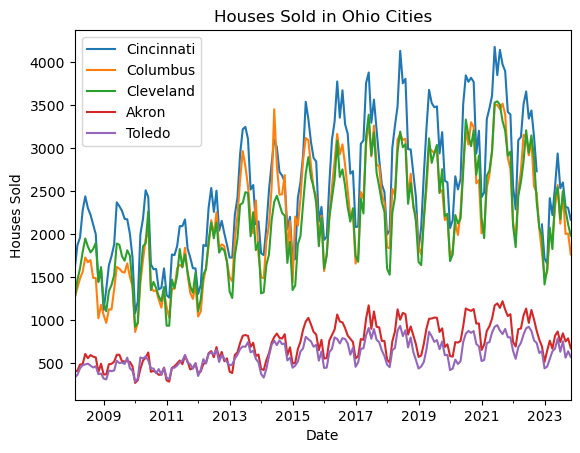

In [194]:
#Plotting the resampled data to examine yearly trends in housing sales.
dates_data_t.plot()
plt.title('Houses Sold in Ohio Cities')
plt.ylabel('Houses Sold')

Text(0.5, 1.0, 'Houses Sold')

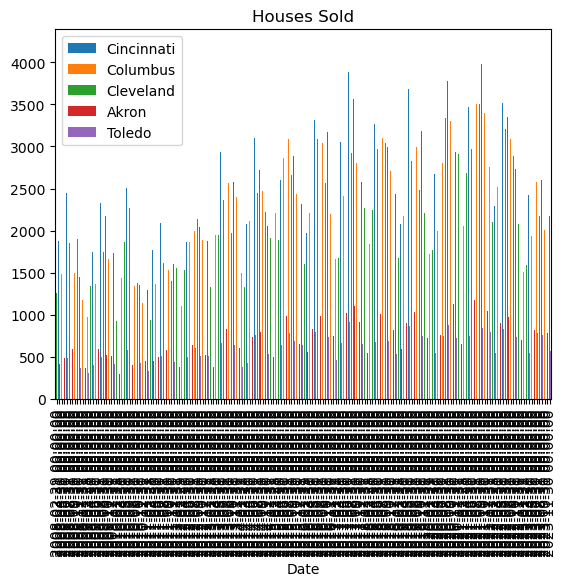

In [196]:
#Attempted to do a bar graph but the data was too convuluted.
dates_data_t.plot(kind='bar')
plt.title("Houses Sold")

In [197]:

#Isolated dates of Ohio "Stay at home" order. 
covid_study_ohio = ohio_metro_sales_df.loc[:, '1/31/2019':'12/31/2020']
covid_study_ohio

,1/31/2019,2/28/2019,3/31/2019,4/30/2019,5/31/2019,6/30/2019,7/31/2019,8/31/2019,9/30/2019,10/31/2019,...,3/31/2020,4/30/2020,5/31/2020,6/30/2020,7/31/2020,8/31/2020,9/30/2020,10/31/2020,11/30/2020,12/31/2020
28,1829,2080,2689,3227,3680,3528,3478,3489,2942,3189,...,2675,2523,2643,3512.0,3849,3774,3821,3773,2940,3205
32,1853,1765,2170,2529,3005,2976,2945,2990,2492,2515,...,2137,1993,2263,2800.0,3194,3044,3304,3248,2593,2632
34,1680,1642,2171,2629,3116,2831,2943,3041,2481,2758,...,2225,2127,2183,2725.0,3335,3148,3025,3208,2693,2916
81,574,591,726,903,1018,1021,1032,1030,865,907,...,747,741,760,930.0,1138,1122,1110,1131,962,964
90,439,463,515,661,867,815,749,770,665,754,...,543,492,525,747.0,845,876,855,875,725,698


In [198]:
#Converting columns to datetime
covid_study_ohio.columns = pd.to_datetime(covid_study_ohio.columns)
covid_study_ohio

,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,...,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31
28,1829,2080,2689,3227,3680,3528,3478,3489,2942,3189,...,2675,2523,2643,3512.0,3849,3774,3821,3773,2940,3205
32,1853,1765,2170,2529,3005,2976,2945,2990,2492,2515,...,2137,1993,2263,2800.0,3194,3044,3304,3248,2593,2632
34,1680,1642,2171,2629,3116,2831,2943,3041,2481,2758,...,2225,2127,2183,2725.0,3335,3148,3025,3208,2693,2916
81,574,591,726,903,1018,1021,1032,1030,865,907,...,747,741,760,930.0,1138,1122,1110,1131,962,964
90,439,463,515,661,867,815,749,770,665,754,...,543,492,525,747.0,845,876,855,875,725,698


In [199]:
#Crete new column for 'Date'
covid_study_ohio['Date'] = ''
covid_study_ohio

,2019-01-31 00:00:00,2019-02-28 00:00:00,2019-03-31 00:00:00,2019-04-30 00:00:00,2019-05-31 00:00:00,2019-06-30 00:00:00,2019-07-31 00:00:00,2019-08-31 00:00:00,2019-09-30 00:00:00,2019-10-31 00:00:00,...,2020-04-30 00:00:00,2020-05-31 00:00:00,2020-06-30 00:00:00,2020-07-31 00:00:00,2020-08-31 00:00:00,2020-09-30 00:00:00,2020-10-31 00:00:00,2020-11-30 00:00:00,2020-12-31 00:00:00,Date
28,1829,2080,2689,3227,3680,3528,3478,3489,2942,3189,...,2523,2643,3512.0,3849,3774,3821,3773,2940,3205,
32,1853,1765,2170,2529,3005,2976,2945,2990,2492,2515,...,1993,2263,2800.0,3194,3044,3304,3248,2593,2632,
34,1680,1642,2171,2629,3116,2831,2943,3041,2481,2758,...,2127,2183,2725.0,3335,3148,3025,3208,2693,2916,
81,574,591,726,903,1018,1021,1032,1030,865,907,...,741,760,930.0,1138,1122,1110,1131,962,964,
90,439,463,515,661,867,815,749,770,665,754,...,492,525,747.0,845,876,855,875,725,698,


In [200]:
#Transpose data and set 'Date' column as index.
covid_study_ohio = covid_study_ohio.set_index('Date').T
covid_study_ohio.head()

Date,,,,,
2019-01-31 00:00:00,1829.0,1853.0,1680.0,574.0,439.0
2019-02-28 00:00:00,2080.0,1765.0,1642.0,591.0,463.0
2019-03-31 00:00:00,2689.0,2170.0,2171.0,726.0,515.0
2019-04-30 00:00:00,3227.0,2529.0,2629.0,903.0,661.0
2019-05-31 00:00:00,3680.0,3005.0,3116.0,1018.0,867.0


In [201]:
#Name blank columns
covid_study_ohio.columns = ['Cincinnati', 'Columbus', 'Cleveland', 'Akron', 'Toledo']
covid_study_ohio.head()

,Cincinnati,Columbus,Cleveland,Akron,Toledo
2019-01-31 00:00:00,1829.0,1853.0,1680.0,574.0,439.0
2019-02-28 00:00:00,2080.0,1765.0,1642.0,591.0,463.0
2019-03-31 00:00:00,2689.0,2170.0,2171.0,726.0,515.0
2019-04-30 00:00:00,3227.0,2529.0,2629.0,903.0,661.0
2019-05-31 00:00:00,3680.0,3005.0,3116.0,1018.0,867.0


In [202]:
#Set x axis and tick locations for Ohio covid lockdown data (for Cincinnati)
x_axis = np.arange(len(covid_study_ohio['Cincinnati']))
tick_locations = [value for value in x_axis]

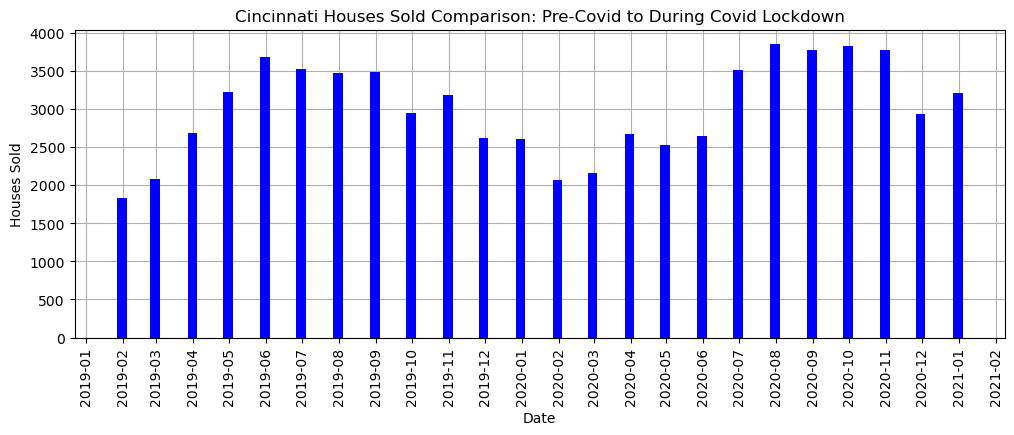

In [204]:
# Set figure size
plt.figure(figsize=(12, 4))

# Plot the bar graph for a specific city (e.g., Cincinnati)
plt.bar(covid_study_ohio.index, covid_study_ohio['Cincinnati'], color='b', alpha=1, align='center', width=8, zorder=3)
plt.grid(zorder=0)

# Customize x-axis ticks
plt.gca().xaxis.set_major_locator(MonthLocator())
plt.xticks(rotation='vertical')

# Set labels and title
plt.title("Cincinnati Houses Sold Comparison: Pre-Covid to During Covid Lockdown")
plt.xlabel('Date')
plt.ylabel('Houses Sold')

# Show the plot
plt.show()

In [146]:
#Exploring the effect of the Covid-19 shut down on home sales
#Filtering for California house sales
california_sales_df = metro_sales_count_renamed.loc[(metro_sales_count_renamed['State'] == 'CA')]
california_sales_df

,Region ID,Size Rank,Region Name,Region Type,State,2/29/2008,3/31/2008,4/30/2008,5/31/2008,6/30/2008,...,2/28/2023,3/31/2023,4/30/2023,5/31/2023,6/30/2023,7/31/2023,8/31/2023,9/30/2023,10/31/2023,11/30/2023
2,753899,2,"Los Angeles, CA",msa,CA,4159,5058,6075,6903,7242,...,4634,6728,6033,7180,7319,6223.0,6964.0,5742.0,5791.0,4965
12,395057,12,"San Francisco, CA",msa,CA,2355,3107,3893,4278,4552,...,1945,2931,2749,3567,3306,2815.0,2980.0,2715.0,2803.0,2296
13,395025,13,"Riverside, CA",msa,CA,2595,3429,3927,4748,4995,...,3243,4339,3989,4801,4635,3858.0,4070.0,3587.0,3430.0,2861
17,395056,17,"San Diego, CA",msa,CA,1462,1677,2280,2624,2563,...,1902,2548,2372,2668,2553,2440.0,2545.0,2076.0,1971.0,1636
26,395045,26,"Sacramento, CA",msa,CA,1463,1772,2286,2637,2934,...,1490,1972,1798,2371,2285,1968.0,2297.0,1978.0,1825.0,1390
35,395059,36,"San Jose, CA",msa,CA,730,924,1099,1273,1395,...,660,1096,1002,1369,1305,1038.0,1187.0,1019.0,1059.0,837
56,394619,57,"Fresno, CA",msa,CA,322,405,517,555,600,...,518,623,594,688,716,634.0,659.0,570.0,618.0,450
62,394357,63,"Bakersfield, CA",msa,CA,439,513,629,723,772,...,564,785,665,775,778,721.0,802.0,661.0,680.0,546
70,394952,71,"Oxnard, CA",msa,CA,391,428,624,588,656,...,383,591,554,626,581,520.0,615.0,483.0,473.0,384
75,395134,77,"Stockton, CA",msa,CA,379,511,698,839,976,...,364,520,426,603,531,515.0,489.0,478.0,433.0,305


In [212]:
#Transposing date columns to become the index
covid_study_california = california_sales_df.loc[:, '1/31/2019':'12/31/2021']
covid_study_california.columns = pd.to_datetime(covid_study_california.columns)
covid_study_california['Date'] = ''
covid_study_california = covid_study_california.set_index('Date').T
covid_study_california

Date,,,,,,,,,,
2019-01-31 00:00:00,5796.0,2171.0,3952.0,1867.0,1816.0,724.0,640.0,720.0,511.0,471.0
2019-02-28 00:00:00,6162.0,2537.0,4028.0,2247.0,2094.0,873.0,574.0,629.0,540.0,511.0
2019-03-31 00:00:00,8224.0,3594.0,5341.0,2863.0,2646.0,1290.0,807.0,865.0,674.0,636.0
2019-04-30 00:00:00,9334.0,4253.0,6000.0,3374.0,2979.0,1446.0,871.0,982.0,842.0,690.0
2019-05-31 00:00:00,10342.0,4979.0,6567.0,3654.0,3453.0,1666.0,991.0,963.0,922.0,816.0
2019-06-30 00:00:00,9733.0,4328.0,5969.0,3359.0,3195.0,1420.0,909.0,910.0,916.0,746.0
2019-07-31 00:00:00,10049.0,4307.0,6522.0,3664.0,3430.0,1446.0,991.0,1071.0,948.0,816.0
2019-08-31 00:00:00,10204.0,4163.0,6288.0,3544.0,3246.0,1418.0,974.0,1158.0,931.0,788.0
2019-09-30 00:00:00,8906.0,3469.0,5560.0,3168.0,2768.0,1171.0,838.0,1011.0,811.0,671.0
2019-10-31 00:00:00,9467.0,4446.0,5994.0,3279.0,3086.0,1345.0,933.0,962.0,895.0,830.0


In [213]:
#Renaming Columns
covid_study_california.columns = ['Los Angeles', 'San Francisco', 'Riverside', 'San Diego', 'Sacramento', 'San Jose', 'Fresno', 'Bakersfield', 'Oxnard', 'Stockton']
covid_study_california.head()

,Los Angeles,San Francisco,Riverside,San Diego,Sacramento,San Jose,Fresno,Bakersfield,Oxnard,Stockton
2019-01-31 00:00:00,5796.0,2171.0,3952.0,1867.0,1816.0,724.0,640.0,720.0,511.0,471.0
2019-02-28 00:00:00,6162.0,2537.0,4028.0,2247.0,2094.0,873.0,574.0,629.0,540.0,511.0
2019-03-31 00:00:00,8224.0,3594.0,5341.0,2863.0,2646.0,1290.0,807.0,865.0,674.0,636.0
2019-04-30 00:00:00,9334.0,4253.0,6000.0,3374.0,2979.0,1446.0,871.0,982.0,842.0,690.0
2019-05-31 00:00:00,10342.0,4979.0,6567.0,3654.0,3453.0,1666.0,991.0,963.0,922.0,816.0


In [214]:
#Set x axis and tick locations for California chart
x_axis = np.arange(len(covid_study_california['Los Angeles']))
tick_locations = [value for value in x_axis]

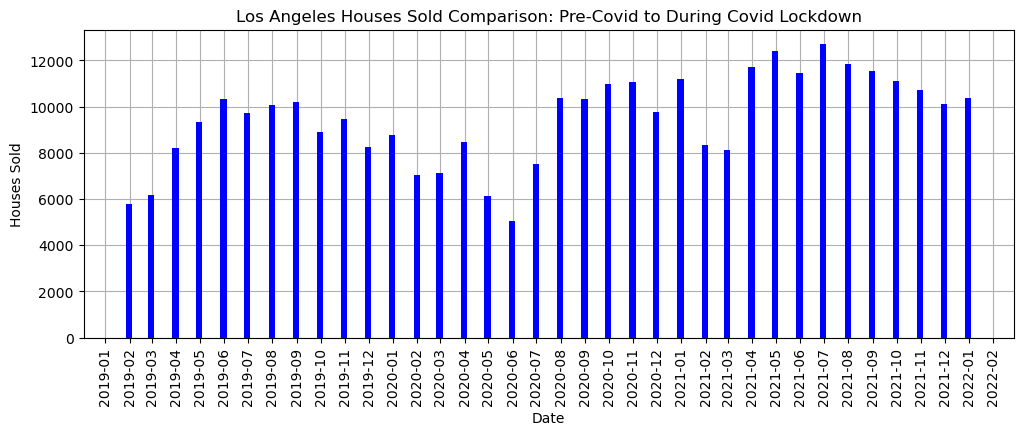

In [215]:
#Creating bar graph for California data
plt.figure(figsize=(12, 4))

plt.bar(covid_study_california.index, covid_study_california['Los Angeles'], color='b', alpha=1, align='center', width=8, zorder=3)
plt.grid(zorder=0)

plt.gca().xaxis.set_major_locator(MonthLocator())
plt.xticks(rotation='vertical')

plt.title("Los Angeles Houses Sold Comparison: Pre-Covid to During Covid Lockdown")
plt.xlabel('Date')
plt.ylabel('Houses Sold')

plt.show()

In [211]:
#Exploring New York City data
new_york_sales_df = metro_sales_count_renamed.loc[(metro_sales_count_renamed['State'] == 'NY')]
new_york_sales_df

,Region ID,Size Rank,Region Name,Region Type,State,2/29/2008,3/31/2008,4/30/2008,5/31/2008,6/30/2008,...,2/28/2023,3/31/2023,4/30/2023,5/31/2023,6/30/2023,7/31/2023,8/31/2023,9/30/2023,10/31/2023,11/30/2023
1,394913,1,"New York, NY",msa,NY,8591,8967,9977,10232,10854,...,8915,11164,10446,12425,14692,13076.0,15184.0,12678.0,12449.0,10864
49,394425,50,"Buffalo, NY",msa,NY,675,743,870,930,1122,...,576,629,600,834,988,979.0,1137.0,1059.0,891.0,923
51,395031,52,"Rochester, NY",msa,NY,741,812,1025,1238,1339,...,521,731,678,925,1156,1078.0,1201.0,1129.0,990.0,984
63,394308,64,"Albany, NY",msa,NY,358,403,439,515,616,...,489,675,607,664,784,719.0,925.0,763.0,751.0,726
88,395143,91,"Syracuse, NY",msa,NY,411,430,501,608,748,...,319,371,317,475,543,552.0,647.0,580.0,628.0,532


In [216]:
#Transposing New York data
new_york_sales_df = new_york_sales_df.loc[:, '1/31/2019':'12/31/2021']
new_york_sales_df.columns = pd.to_datetime(new_york_sales_df.columns)
new_york_sales_df['Date'] = ''
new_york_sales_df = new_york_sales_df.set_index('Date').T
new_york_sales_df

Date,,,,,
2019-01-31 00:00:00,14390.0,785.0,828.0,481.0,503.0
2019-02-28 00:00:00,11983.0,657.0,763.0,407.0,387.0
2019-03-31 00:00:00,14232.0,867.0,937.0,477.0,461.0
2019-04-30 00:00:00,15094.0,883.0,1105.0,555.0,531.0
2019-05-31 00:00:00,17451.0,1091.0,1324.0,655.0,673.0
2019-06-30 00:00:00,18513.0,1091.0,1385.0,659.0,763.0
2019-07-31 00:00:00,20217.0,1273.0,1567.0,762.0,844.0
2019-08-31 00:00:00,20326.0,1394.0,1700.0,797.0,841.0
2019-09-30 00:00:00,17239.0,1218.0,1358.0,650.0,785.0
2019-10-31 00:00:00,17836.0,1217.0,1343.0,683.0,829.0


In [217]:
new_york_sales_df.columns = ['New York', 'Buffalo', 'Rochester', 'Albany', 'Syracuse']
new_york_sales_df.head()

,New York,Buffalo,Rochester,Albany,Syracuse
2019-01-31 00:00:00,14390.0,785.0,828.0,481.0,503.0
2019-02-28 00:00:00,11983.0,657.0,763.0,407.0,387.0
2019-03-31 00:00:00,14232.0,867.0,937.0,477.0,461.0
2019-04-30 00:00:00,15094.0,883.0,1105.0,555.0,531.0
2019-05-31 00:00:00,17451.0,1091.0,1324.0,655.0,673.0


In [218]:
x_axis = np.arange(len(new_york_sales_df['New York']))
tick_locations = [value for value in x_axis]

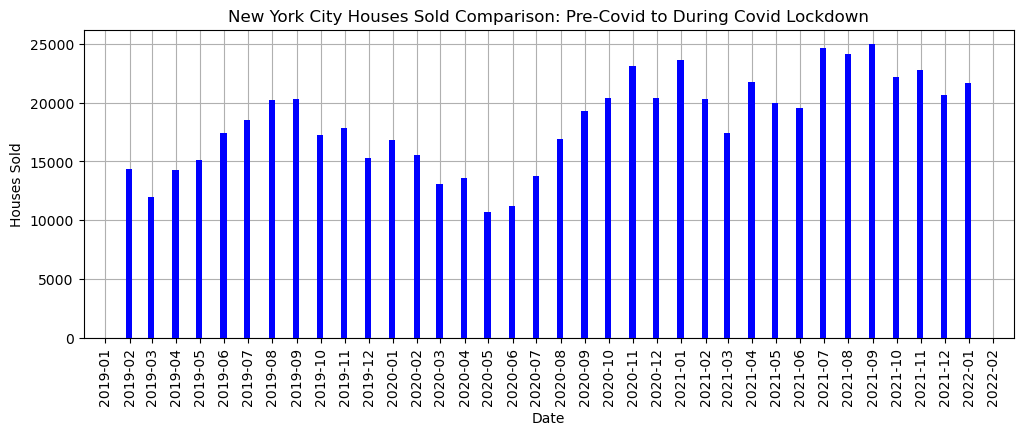

In [220]:
plt.figure(figsize=(12, 4))

plt.bar(new_york_sales_df.index, new_york_sales_df['New York'], color='b', alpha=1, align='center', width=8, zorder=3)
plt.grid(zorder=0)

plt.gca().xaxis.set_major_locator(MonthLocator())
plt.xticks(rotation='vertical')

plt.title("New York City Houses Sold Comparison: Pre-Covid to During Covid Lockdown")
plt.xlabel('Date')
plt.ylabel('Houses Sold')

plt.show()